# Phoneme Sequence Recognition with Simple RNN - Part B

## Continuation from Part A

This notebook continues from Part A where we:
1. ✅ Learned about phonetics and co-articulation
2. ✅ Visualized waveforms and spectrograms of /k/, /b/, /h/
3. ✅ Understood why temporal context is necessary
4. ✅ Implemented activation functions (tanh, softmax)
5. ✅ Created synthetic phoneme dataset with co-articulation
6. ✅ Started SimpleRNN implementation

In this Part B, we will:
1. Complete the SimpleRNN implementation
2. Train the RNN on phoneme sequences
3. Visualize predictions and hidden states
4. Compare RNN vs DNN performance
5. Understand RNN limitations

**Note**: Run Part A first to generate the dataset and define the SimpleRNN class!

## Setup: Import from Part A

If you're running this notebook separately, you'll need to run the relevant cells from Part A first. For convenience, here's a quick setup:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported")
print("\n⚠️  Make sure you've run Part A to:")
print("   1. Define activation functions (tanh, softmax)")
print("   2. Create PhonemeDataset class")
print("   3. Generate X_train, y_train, X_val, y_val")
print("   4. Define SimpleRNN class")

✓ Libraries imported

⚠️  Make sure you've run Part A to:
   1. Define activation functions (tanh, softmax)
   2. Create PhonemeDataset class
   3. Generate X_train, y_train, X_val, y_val
   4. Define SimpleRNN class


# RNN Forward Propagation: A Detailed Visual Explanation

## Overview

The forward pass in an RNN processes a sequence **one timestep at a time**, maintaining a **hidden state** that carries information from previous timesteps.

---

## 1. The Big Picture: Sequential Processing

```
Input Sequence:  [x₀] → [x₁] → [x₂] → [x₃] → ... → [xₜ]
                   ↓      ↓      ↓      ↓           ↓
Hidden States:   [h₀] → [h₁] → [h₂] → [h₃] → ... → [hₜ]
                   ↓      ↓      ↓      ↓           ↓
Outputs:         [y₀]   [y₁]   [y₂]   [y₃]   ...   [yₜ]
```

**Key Concept**: Each hidden state `hₜ` depends on:
- Current input `xₜ`
- Previous hidden state `hₜ₋₁`

This creates a **temporal dependency chain** through the sequence.

---

## 2. Initialization: Starting Point

```python
h = np.zeros((self.hidden_dim, 1))
```

### Diagram: Initial State

```
┌─────────────────────────────────────┐
│  Initial Hidden State (h₀)          │
│                                     │
│  ┌───┐                              │
│  │ 0 │  ← All zeros                 │
│  │ 0 │     (hidden_dim × 1)         │
│  │ 0 │                              │
│  │ . │                              │
│  │ . │                              │
│  └───┘                              │
│                                     │
│  Shape: (hidden_dim, 1)             │
│  Example: (32, 1) if hidden_dim=32  │
└─────────────────────────────────────┘
```

**Why zeros?**
- No prior context at the start
- The network will learn what initial state works best
- Alternative: learnable initial state (advanced technique)

---

## 3. Single Timestep: Detailed Breakdown

Let's examine what happens at **timestep t**:

### Step 3.1: Extract Current Input

```python
x_t = X[t].reshape(-1, 1)
```

### Diagram: Input Extraction

```
Full Input Sequence X:
┌─────────────────────────────────────────────┐
│  Timestep:    0      1      2      3    ... │
│            ┌────┐ ┌────┐ ┌────┐ ┌────┐      │
│            │x₀  │ │x₁  │ │x₂  │ │x₃  │      │
│            │feat│ │feat│ │feat│ │feat│      │
│            └────┘ └────┘ └────┘ └────┘      │
│                     ↑                        │
│                     │ Extract at t=1         │
│                     ↓                        │
│                  ┌────┐                      │
│            x_t = │x₁  │  (feature_dim × 1)   │
│                  │feat│                      │
│                  └────┘                      │
└─────────────────────────────────────────────┘

Example:
If X[1] = [0.5, 0.3, 0.8, 0.2, ...]  (feature_dim = 10)

After reshape:
x_t = [[0.5],
       [0.3],
       [0.8],
       [0.2],
       [...]]  ← Shape: (10, 1)
```

---

### Step 3.2: Compute New Hidden State

```python
h = tanh(np.dot(self.W_hh, h) + np.dot(self.W_xh, x_t) + self.b_h)
```

This is the **core RNN computation**. Let's break it down:

### Diagram: Hidden State Computation (Detailed)

```
┌─────────────────────────────────────────────────────────────────┐
│                    HIDDEN STATE UPDATE                          │
│                                                                 │
│  Previous Hidden State (h_{t-1})        Current Input (x_t)    │
│         ┌───┐                                ┌───┐             │
│         │0.2│                                │0.5│             │
│         │0.8│                                │0.3│             │
│         │0.1│                                │0.8│             │
│         │ . │                                │ . │             │
│         └───┘                                └───┘             │
│      (hidden_dim×1)                      (feature_dim×1)       │
│           ↓                                    ↓               │
│           │                                    │               │
│    ┌──────┴──────┐                    ┌───────┴────────┐      │
│    │   W_hh      │                    │     W_xh       │      │
│    │ (hidden×    │                    │  (hidden×      │      │
│    │  hidden)    │                    │   feature)     │      │
│    └──────┬──────┘                    └───────┬────────┘      │
│           │                                    │               │
│           ↓                                    ↓               │
│      Matrix Multiply                     Matrix Multiply      │
│           │                                    │               │
│           ↓                                    ↓               │
│    ┌─────────────┐                    ┌──────────────┐        │
│    │ W_hh @ h    │                    │ W_xh @ x_t   │        │
│    │  (hidden×1) │                    │  (hidden×1)  │        │
│    └──────┬──────┘                    └──────┬───────┘        │
│           │                                   │                │
│           └───────────┬───────────────────────┘                │
│                       │                                        │
│                       ↓                                        │
│                   ┌───────┐         ┌────┐                    │
│                   │  ADD  │    +    │ b_h│  (bias)            │
│                   └───┬───┘         └─┬──┘                    │
│                       │                │                       │
│                       └────────┬───────┘                       │
│                                ↓                               │
│                          ┌─────────┐                           │
│                          │  tanh   │  (activation)             │
│                          └────┬────┘                           │
│                               ↓                                │
│                          ┌────────┐                            │
│                          │   h_t  │  (new hidden state)        │
│                          └────────┘                            │
│                         (hidden_dim×1)                         │
└─────────────────────────────────────────────────────────────────┘
```

### Mathematical Breakdown:

```
Step 1: Recurrent Connection (memory from past)
   W_hh @ h_{t-1}  →  Transforms previous hidden state
   
   Example dimensions:
   (32 × 32) @ (32 × 1) = (32 × 1)

Step 2: Input Connection (new information)
   W_xh @ x_t  →  Transforms current input
   
   Example dimensions:
   (32 × 10) @ (10 × 1) = (32 × 1)

Step 3: Combine and Add Bias
   W_hh @ h_{t-1} + W_xh @ x_t + b_h
   
   (32 × 1) + (32 × 1) + (32 × 1) = (32 × 1)

Step 4: Apply Activation
   h_t = tanh(...)
   
   Squashes values to [-1, 1] range
```

---

### Step 3.3: Compute Output

```python
logits = np.dot(self.W_hy, h) + self.b_y
y_t = softmax(logits.flatten())
```

### Diagram: Output Computation

```
┌─────────────────────────────────────────────────────────┐
│              OUTPUT COMPUTATION                         │
│                                                         │
│  Hidden State (h_t)                                     │
│      ┌───┐                                              │
│      │0.7│                                              │
│      │0.3│                                              │
│      │0.9│                                              │
│      │ . │                                              │
│      └─┬─┘                                              │
│        │  (hidden_dim × 1)                              │
│        ↓                                                │
│   ┌────────────┐                                        │
│   │    W_hy    │  (output_dim × hidden_dim)            │
│   └─────┬──────┘                                        │
│         │                                               │
│         ↓                                               │
│    Matrix Multiply                                      │
│         │                                               │
│         ↓                                               │
│   ┌──────────┐         ┌────┐                          │
│   │ W_hy @ h │    +    │ b_y│  (bias)                  │
│   └────┬─────┘         └─┬──┘                          │
│        │                 │                              │
│        └────────┬────────┘                              │
│                 ↓                                       │
│            ┌─────────┐                                  │
│            │ logits  │  (output_dim × 1)               │
│            └────┬────┘                                  │
│                 │                                       │
│                 ↓                                       │
│            ┌─────────┐                                  │
│            │ softmax │  (convert to probabilities)     │
│            └────┬────┘                                  │
│                 ↓                                       │
│            ┌─────────┐                                  │
│            │   y_t   │  (probability distribution)     │
│            └─────────┘                                  │
│                                                         │
│  Example (5 phonemes):                                 │
│  logits = [2.1, 0.5, -1.2, 3.4, 0.8]                   │
│           ↓ softmax                                     │
│  y_t = [0.15, 0.03, 0.01, 0.78, 0.04]                  │
│         ↑                    ↑                          │
│         └─── Sums to 1.0 ───┘                          │
└─────────────────────────────────────────────────────────┘
```

---

### Step 3.4: Store Results

```python
hidden_states.append(h.copy())
outputs.append(y_t)
```

### Diagram: Storage

```
┌────────────────────────────────────────────────┐
│         STORING TIMESTEP RESULTS               │
│                                                │
│  hidden_states = []  ← List of all h_t         │
│  outputs = []        ← List of all y_t         │
│                                                │
│  After timestep t:                             │
│                                                │
│  hidden_states.append(h.copy())                │
│  ┌─────────────────────────────────┐           │
│  │ [h₀, h₁, h₂, ..., h_t]          │           │
│  └─────────────────────────────────┘           │
│                                                │
│  outputs.append(y_t)                           │
│  ┌─────────────────────────────────┐           │
│  │ [y₀, y₁, y₂, ..., y_t]          │           │
│  └─────────────────────────────────┘           │
│                                                │
│  ⚠️  Important: h.copy()                       │
│     Without .copy(), all entries would         │
│     reference the same object!                 │
└────────────────────────────────────────────────┘
```

---

## 4. Complete Forward Pass: Full Sequence

### Diagram: Unrolled RNN Through Time

```
Timestep:     t=0           t=1           t=2           t=3
            
Input:       [x₀]          [x₁]          [x₂]          [x₃]
              ↓             ↓             ↓             ↓
            ┌───┐         ┌───┐         ┌───┐         ┌───┐
            │   │ ──────→ │   │ ──────→ │   │ ──────→ │   │
h₋₁ = 0 ──→ │RNN│         │RNN│         │RNN│         │RNN│
            │   │         │   │         │   │         │   │
            └─┬─┘         └─┬─┘         └─┬─┘         └─┬─┘
              ↓             ↓             ↓             ↓
            [h₀]          [h₁]          [h₂]          [h₃]
              ↓             ↓             ↓             ↓
            [y₀]          [y₁]          [y₂]          [y₃]

Each RNN cell performs:
┌─────────────────────────────────────┐
│ h_t = tanh(W_hh @ h_{t-1} +         │
│            W_xh @ x_t +              │
│            b_h)                      │
│                                     │
│ y_t = softmax(W_hy @ h_t + b_y)     │
└─────────────────────────────────────┘

Information Flow:
• Horizontal arrows (→): Hidden state carries temporal context
• Vertical arrows (↓): Current timestep processing
```

---

## 5. Detailed Example: Processing "cat" = [/k/, /æ/, /t/]

### Setup:
- 3 phonemes in sequence
- feature_dim = 10 (acoustic features per frame)
- hidden_dim = 32
- output_dim = 5 (5 possible phonemes)

### Diagram: Step-by-Step Execution

```
┌─────────────────────────────────────────────────────────────────┐
│                    TIMESTEP 0: /k/                              │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  Input: x₀ = [0.2, 0.8, 0.1, ...]  (10 features for /k/)      │
│  Previous: h₋₁ = [0, 0, 0, ...]     (32 zeros - initial)       │
│                                                                 │
│  Computation:                                                   │
│  ┌─────────────────────────────────────────────────────┐       │
│  │ W_hh @ h₋₁ = [0, 0, ...]  (all zeros)              │       │
│  │ W_xh @ x₀  = [0.5, -0.3, 0.8, ...]  (from input)   │       │
│  │ Sum + bias = [0.6, -0.2, 0.9, ...]                 │       │
│  │ h₀ = tanh(...) = [0.54, -0.20, 0.72, ...]          │       │
│  └─────────────────────────────────────────────────────┘       │
│                                                                 │
│  Output:                                                        │
│  ┌─────────────────────────────────────────────────────┐       │
│  │ logits = W_hy @ h₀ + b_y = [2.1, 0.5, -1.2, ...]   │       │
│  │ y₀ = softmax(logits) = [0.78, 0.15, 0.01, ...]     │       │
│  │                          ↑                          │       │
│  │                    Predicts /k/ (78% confidence)    │       │
│  └─────────────────────────────────────────────────────┘       │
│                                                                 │
│  Store: hidden_states[0] = h₀, outputs[0] = y₀                 │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│                    TIMESTEP 1: /æ/                              │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  Input: x₁ = [0.7, 0.3, 0.5, ...]  (10 features for /æ/)      │
│  Previous: h₀ = [0.54, -0.20, 0.72, ...]  (from timestep 0)   │
│                                                                 │
│  Computation:                                                   │
│  ┌─────────────────────────────────────────────────────┐       │
│  │ W_hh @ h₀  = [0.3, 0.6, -0.2, ...]  (memory!)      │       │
│  │ W_xh @ x₁  = [0.8, 0.1, 0.4, ...]   (new input)    │       │
│  │ Sum + bias = [1.2, 0.8, 0.3, ...]                  │       │
│  │ h₁ = tanh(...) = [0.84, 0.66, 0.29, ...]           │       │
│  │                    ↑                                │       │
│  │              Influenced by both /k/ and /æ/!        │       │
│  └─────────────────────────────────────────────────────┘       │
│                                                                 │
│  Output:                                                        │
│  ┌─────────────────────────────────────────────────────┐       │
│  │ logits = W_hy @ h₁ + b_y = [0.3, 3.2, 0.8, ...]    │       │
│  │ y₁ = softmax(logits) = [0.05, 0.89, 0.03, ...]     │       │
│  │                               ↑                     │       │
│  │                    Predicts /æ/ (89% confidence)    │       │
│  └─────────────────────────────────────────────────────┘       │
│                                                                 │
│  Store: hidden_states[1] = h₁, outputs[1] = y₁                 │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│                    TIMESTEP 2: /t/                              │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  Input: x₂ = [0.3, 0.9, 0.2, ...]  (10 features for /t/)      │
│  Previous: h₁ = [0.84, 0.66, 0.29, ...]  (from timestep 1)    │
│                                                                 │
│  Computation:                                                   │
│  ┌─────────────────────────────────────────────────────┐       │
│  │ W_hh @ h₁  = [0.5, 0.4, 0.7, ...]  (memory!)       │       │
│  │ W_xh @ x₂  = [0.2, 0.8, 0.1, ...]  (new input)     │       │
│  │ Sum + bias = [0.8, 1.3, 0.9, ...]                  │       │
│  │ h₂ = tanh(...) = [0.66, 0.86, 0.72, ...]           │       │
│  │                    ↑                                │       │
│  │         Influenced by /k/, /æ/, and /t/!           │       │
│  └─────────────────────────────────────────────────────┘       │
│                                                                 │
│  Output:                                                        │
│  ┌─────────────────────────────────────────────────────┐       │
│  │ logits = W_hy @ h₂ + b_y = [0.1, 0.4, 0.2, 3.5...] │       │
│  │ y₂ = softmax(logits) = [0.02, 0.03, 0.02, 0.91...] │       │
│  │                                              ↑      │       │
│  │                    Predicts /t/ (91% confidence)    │       │
│  └─────────────────────────────────────────────────────┘       │
│                                                                 │
│  Store: hidden_states[2] = h₂, outputs[2] = y₂                 │
└─────────────────────────────────────────────────────────────────┘
```

---

## 6. Key Insights: Why This Works

### Information Flow Diagram

```
┌────────────────────────────────────────────────────────────┐
│              TEMPORAL CONTEXT ACCUMULATION                 │
│                                                            │
│  Timestep 0:                                               │
│  h₀ contains: Information about /k/                        │
│                                                            │
│  Timestep 1:                                               │
│  h₁ contains: Information about /k/ + /æ/                  │
│               (via W_hh @ h₀)                              │
│                                                            │
│  Timestep 2:                                               │
│  h₂ contains: Information about /k/ + /æ/ + /t/            │
│               (via W_hh @ h₁)                              │
│                                                            │
│  This is why RNNs can handle co-articulation!              │
│  Each prediction uses context from previous phonemes.      │
└────────────────────────────────────────────────────────────┘
```

### Comparison: DNN vs RNN

```
┌─────────────────────────────────────────────────────────────┐
│                    DNN (No Memory)                          │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  t=0: x₀ → [DNN] → y₀  (only sees current frame)          │
│  t=1: x₁ → [DNN] → y₁  (no memory of x₀)                  │
│  t=2: x₂ → [DNN] → y₂  (no memory of x₀, x₁)              │
│                                                             │
│  Problem: Can't handle co-articulation!                    │
│  If x₁ is ambiguous, DNN has no context to help.          │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│                    RNN (With Memory)                        │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  t=0: x₀, h₋₁ → [RNN] → y₀, h₀                            │
│  t=1: x₁, h₀  → [RNN] → y₁, h₁  (remembers x₀)            │
│  t=2: x₂, h₁  → [RNN] → y₂, h₂  (remembers x₀, x₁)        │
│                                                             │
│  Solution: Hidden state carries temporal context!          │
│  If x₁ is ambiguous, h₀ provides context from x₀.         │
└─────────────────────────────────────────────────────────────┘
```

---

## 7. Matrix Dimensions Reference

For a concrete example with:
- `feature_dim = 10` (input features)
- `hidden_dim = 32` (hidden state size)
- `output_dim = 5` (number of phonemes)

```
┌─────────────────────────────────────────────────────────┐
│                  WEIGHT MATRICES                        │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  W_xh: (32 × 10)  - Input to hidden                    │
│  W_hh: (32 × 32)  - Hidden to hidden (recurrent)       │
│  W_hy: (5 × 32)   - Hidden to output                   │
│                                                         │
│  b_h:  (32 × 1)   - Hidden bias                        │
│  b_y:  (5 × 1)    - Output bias                        │
│                                                         │
├─────────────────────────────────────────────────────────┤
│                  ACTIVATIONS                            │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  x_t:  (10 × 1)   - Input at timestep t                │
│  h_t:  (32 × 1)   - Hidden state at timestep t         │
│  y_t:  (5 × 1)    - Output probabilities at timestep t │
│                                                         │
├─────────────────────────────────────────────────────────┤
│                  OPERATIONS                             │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  W_xh @ x_t:  (32×10) @ (10×1) = (32×1)               │
│  W_hh @ h_{t-1}: (32×32) @ (32×1) = (32×1)            │
│  Sum:         (32×1) + (32×1) + (32×1) = (32×1)       │
│  tanh:        (32×1) → (32×1)                          │
│                                                         │
│  W_hy @ h_t:  (5×32) @ (32×1) = (5×1)                 │
│  Add bias:    (5×1) + (5×1) = (5×1)                    │
│  softmax:     (5×1) → (5×1)                            │
│                                                         │
└─────────────────────────────────────────────────────────┘
```

---

## 8. Common Pitfalls and Solutions

### Pitfall 1: Forgetting to Copy Hidden State

```python
# ❌ WRONG
hidden_states.append(h)  # All entries reference same object!

# ✅ CORRECT
hidden_states.append(h.copy())  # Each entry is independent
```

### Pitfall 2: Wrong Reshape

```python
# ❌ WRONG
x_t = X[t]  # Shape might be (10,) instead of (10, 1)

# ✅ CORRECT
x_t = X[t].reshape(-1, 1)  # Ensures column vector (10, 1)
```

### Pitfall 3: Not Flattening Before Softmax

```python
# ❌ WRONG
y_t = softmax(logits)  # logits is (5, 1), softmax expects (5,)

# ✅ CORRECT
y_t = softmax(logits.flatten())  # Convert to 1D array
```

---

## 9. Summary: The Forward Pass Loop

```python
# Pseudocode with annotations
def forward(X):
    h = zeros(hidden_dim, 1)          # 1. Initialize hidden state
    hidden_states = []                 # 2. Storage for all h_t
    outputs = []                       # 3. Storage for all y_t
    
    for t in range(seq_length):        # 4. Loop through time
        x_t = X[t].reshape(-1, 1)      # 5. Get current input
        
        # 6. Update hidden state (THE CORE RNN EQUATION)
        h = tanh(W_hh @ h + W_xh @ x_t + b_h)
        #        ↑         ↑
        #     memory    new info
        
        # 7. Compute output
        logits = W_hy @ h + b_y
        y_t = softmax(logits.flatten())
        
        # 8. Store results
        hidden_states.append(h.copy())
        outputs.append(y_t)
    
    return outputs, hidden_states
```

---

## 10. Visualization: Information Flow

```
┌──────────────────────────────────────────────────────────────┐
│         HOW INFORMATION FLOWS THROUGH THE RNN                │
│                                                              │
│  Input Sequence: "The cat sat"                               │
│                                                              │
│  Frame 0: [acoustic features for "The"]                      │
│     ↓                                                        │
│  h₀ = f(x₀, h₋₁)  ← Encodes "The"                           │
│     ↓                                                        │
│  y₀ = "The" (predicted)                                      │
│                                                              │
│  Frame 1: [acoustic features for "cat"]                      │
│     ↓                                                        │
│  h₁ = f(x₁, h₀)   ← Encodes "cat" + remembers "The"         │
│     ↓                                                        │
│  y₁ = "cat" (predicted with context)                         │
│                                                              │
│  Frame 2: [acoustic features for "sat"]                      │
│     ↓                                                        │
│  h₂ = f(x₂, h₁)   ← Encodes "sat" + remembers "The cat"     │
│     ↓                                                        │
│  y₂ = "sat" (predicted with full context)                    │
│                                                              │
│  Key: Each h_t is a compressed representation of             │
│       everything seen so far!                                │
└──────────────────────────────────────────────────────────────┘
```

---

This detailed explanation should give you a complete understanding of how RNN forward propagation works at every level, from high-level concepts to low-level matrix operations!

## Frame Size Estimation

### Temporal Duration (Milliseconds)

In speech processing, standard frame parameters are:

```python
# Typical values for speech analysis
SAMPLE_RATE = 22050  # Hz (or 16000 Hz for speech)
FRAME_SIZE = 512     # samples per frame (n_fft)
HOP_SIZE = 256       # samples between frames

# Calculate frame duration
frame_duration_ms = (FRAME_SIZE / SAMPLE_RATE) * 1000
```

**Calculation:**
```
Frame duration = 512 / 22050 × 1000 = 23.2 ms
```

**Standard ranges:**
- **20-25 ms** is typical for speech recognition
- **10 ms hop** between frames (50% overlap)

### Memory Size (Bytes)

For the feature vector at each frame:

```python
feature_dim = 10  # Number of features per frame
```

**Raw features (float64):**
```
Size = 10 features × 8 bytes/float64 = 80 bytes per frame
```

**Raw features (float32):**
```
Size = 10 features × 4 bytes/float32 = 40 bytes per frame
```

### Complete Breakdown

```
┌─────────────────────────────────────────────────────────────┐
│                    FRAME SPECIFICATIONS                     │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  TEMPORAL:                                                  │
│  • Frame duration:     ~23 ms (512 samples @ 22050 Hz)     │
│  • Hop size:           ~12 ms (256 samples)                │
│  • Overlap:            50% (typical)                        │
│  • Frames per second:  ~86 frames/sec                      │
│                                                             │
│  MEMORY (per frame):                                        │
│  • Feature vector:     10 floats                           │
│  • Size (float64):     80 bytes                            │
│  • Size (float32):     40 bytes                            │
│                                                             │
│  FOR A SEQUENCE:                                            │
│  • 1 second of audio:  ~86 frames                          │
│  • Memory (float32):   86 × 40 = 3,440 bytes (~3.4 KB)    │
│  • Memory (float64):   86 × 80 = 6,880 bytes (~6.9 KB)    │
│                                                             │
│  EXAMPLE: 10-second audio clip                             │
│  • Total frames:       ~860 frames                         │
│  • Memory (float32):   ~34 KB                              │
│  • Memory (float64):   ~69 KB                              │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

### Comparison with Raw Audio

```
┌─────────────────────────────────────────────────────────────┐
│              RAW AUDIO vs FEATURES                          │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  RAW AUDIO (1 second @ 22050 Hz, 16-bit):                 │
│  • Samples:     22,050                                      │
│  • Size:        22,050 × 2 bytes = 44,100 bytes (~44 KB)  │
│                                                             │
│  FEATURES (1 second, 10-dim):                              │
│  • Frames:      ~86                                         │
│  • Size:        86 × 40 bytes = 3,440 bytes (~3.4 KB)     │
│                                                             │
│  COMPRESSION RATIO: ~13:1                                   │
│  (Features are much more compact!)                          │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

### Visualization: Frame Timeline

```
Time (ms):  0    23    46    69    92   115   138   161   184
            |     |     |     |     |     |     |     |     |
Frames:    [F0]  [F1]  [F2]  [F3]  [F4]  [F5]  [F6]  [F7]  [F8]
            ↓     ↓     ↓     ↓     ↓     ↓     ↓     ↓     ↓
Features:  10    10    10    10    10    10    10    10    10
           dim   dim   dim   dim   dim   dim   dim   dim   dim

Each frame:
┌──────────────────────────────┐
│ Frame duration: 23 ms        │
│ Feature vector: 10 floats    │
│ Memory: 40 bytes (float32)   │
└──────────────────────────────┘

Overlap (with hop_size = 256):
Frame 0: samples [0    - 511]
Frame 1: samples [256  - 767]   ← 50% overlap
Frame 2: samples [512  - 1023]
...
```

### What These 10 Features Might Represent

In real speech processing, these could be:

```
┌─────────────────────────────────────────────────────────────┐
│           TYPICAL 10-DIMENSIONAL FEATURES                   │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  Option 1: MFCCs (Mel-Frequency Cepstral Coefficients)     │
│  • 10 MFCC coefficients                                     │
│  • Captures spectral envelope                              │
│  • Standard for speech recognition                         │
│                                                             │
│  Option 2: Mixed features                                   │
│  • 6 MFCCs                                                  │
│  • 1 Energy                                                 │
│  • 1 Zero-crossing rate                                     │
│  • 1 Spectral centroid                                      │
│  • 1 Spectral rolloff                                       │
│                                                             │
│  Option 3: Formants + Energy                               │
│  • 3 Formant frequencies (F1, F2, F3)                      │
│  • 3 Formant bandwidths                                     │
│  • 2 Energy measures                                        │
│  • 2 Spectral features                                      │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

### Summary Table

| Parameter | Value |
|-----------|-------|
| **Frame duration** | ~23 ms |
| **Hop duration** | ~12 ms |
| **Feature dimension** | 10 |
| **Bytes per frame (float32)** | 40 bytes |
| **Bytes per frame (float64)** | 80 bytes |
| **Frames per second** | ~86 |
| **Memory for 1 sec (float32)** | ~3.4 KB |
| **Compression vs raw audio** | ~13:1 |

### Practical Implications

```python
# For a typical phoneme recognition task:

# Average phoneme duration: 50-100 ms
phoneme_duration_ms = 75  # average

# Frames per phoneme
frames_per_phoneme = phoneme_duration_ms / 23  # ≈ 3.3 frames

# For a 5-phoneme word (e.g., "hello")
word_frames = 5 * 3.3  # ≈ 16-17 frames
word_duration_ms = 5 * 75  # ≈ 375 ms

# Memory for this word
word_memory_bytes = 17 * 40  # ≈ 680 bytes (float32)
```

So in the notebook's synthetic dataset:
- **Each frame** ≈ 23 ms, 40 bytes
- **Each phoneme** ≈ 3-4 frames, 120-160 bytes
- **Each sequence** (20 frames) ≈ 460 ms, 800 bytes

This is very efficient compared to raw audio!

## Complete SimpleRNN Implementation

Here's the complete SimpleRNN class (in case you need it):

In [5]:
# Activation functions (from Part A)
def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

class SimpleRNN:
    """Simple RNN implementation from scratch."""
    
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # Initialize weights
        self.W_xh = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.W_hh = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.W_hy = np.random.randn(output_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.b_h = np.zeros((hidden_dim, 1))
        self.b_y = np.zeros((output_dim, 1))
        
        # For tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def forward(self, X):
        seq_length = X.shape[0]
        h = np.zeros((self.hidden_dim, 1))
        hidden_states = []
        outputs = []
        
        for t in range(seq_length):
            x_t = X[t].reshape(-1, 1)
            h = tanh(np.dot(self.W_hh, h) + np.dot(self.W_xh, x_t) + self.b_h)
            logits = np.dot(self.W_hy, h) + self.b_y
            y_t = softmax(logits.flatten())
            hidden_states.append(h.copy())
            outputs.append(y_t)
        
        return outputs, hidden_states
    
    def compute_loss(self, outputs, targets):
        seq_length = len(outputs)
        loss = 0.0
        for t in range(seq_length):
            loss += -np.log(outputs[t][targets[t]] + 1e-8)
        return loss / seq_length
    
    def backward(self, X, targets, outputs, hidden_states):
        seq_length = X.shape[0]
        dW_xh = np.zeros_like(self.W_xh)
        dW_hh = np.zeros_like(self.W_hh)
        dW_hy = np.zeros_like(self.W_hy)
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)
        dh_next = np.zeros((self.hidden_dim, 1))
        
        for t in reversed(range(seq_length)):
            dy = outputs[t].copy()
            dy[targets[t]] -= 1
            dy = dy.reshape(-1, 1) / seq_length
            
            dW_hy += np.dot(dy, hidden_states[t].T)
            db_y += dy
            
            dh = np.dot(self.W_hy.T, dy) + dh_next
            dh_raw = dh * (1 - hidden_states[t] ** 2)
            
            x_t = X[t].reshape(-1, 1)
            dW_xh += np.dot(dh_raw, x_t.T)
            db_h += dh_raw
            
            if t > 0:
                dW_hh += np.dot(dh_raw, hidden_states[t-1].T)
                dh_next = np.dot(self.W_hh.T, dh_raw)
            else:
                h_prev = np.zeros((self.hidden_dim, 1))
                dW_hh += np.dot(dh_raw, h_prev.T)
        
        # Gradient clipping
        for grad in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
            np.clip(grad, -5, 5, out=grad)
        
        return dW_xh, dW_hh, dW_hy, db_h, db_y
    
    def update_parameters(self, dW_xh, dW_hh, dW_hy, db_h, db_y):
        self.W_xh -= self.learning_rate * dW_xh
        self.W_hh -= self.learning_rate * dW_hh
        self.W_hy -= self.learning_rate * dW_hy
        self.b_h -= self.learning_rate * db_h
        self.b_y -= self.learning_rate * db_y
    
    def train_step(self, X, y):
        outputs, hidden_states = self.forward(X)
        loss = self.compute_loss(outputs, y)
        grads = self.backward(X, y, outputs, hidden_states)
        self.update_parameters(*grads)
        return loss
    
    def predict(self, X):
        outputs, _ = self.forward(X)
        predictions = np.array([np.argmax(out) for out in outputs])
        return predictions
    
    def evaluate(self, X, y):
        """Evaluate on a dataset.
        
        Args:
            X: Input sequences (n_sequences, seq_length, input_dim)
            y: Target labels (n_sequences, seq_length)
        
        Returns:
            avg_loss: Average loss
            accuracy: Frame-level accuracy
        """
        total_loss = 0.0
        correct = 0
        total = 0
        
        for i in range(len(X)):
            outputs, _ = self.forward(X[i])
            loss = self.compute_loss(outputs, y[i])
            total_loss += loss
            
            predictions = np.array([np.argmax(out) for out in outputs])
            correct += np.sum(predictions == y[i])
            total += len(y[i])
        
        avg_loss = total_loss / len(X)
        accuracy = correct / total
        
        return avg_loss, accuracy

print("✓ SimpleRNN class defined")

✓ SimpleRNN class defined


## Generate Dataset (if needed)

If you haven't run Part A, generate the dataset here:

In [ ]:
class PhonemeDataset:
    """Generate synthetic phoneme sequences for RNN training."""
    
    def __init__(self, n_phonemes=5, feature_dim=8, seq_length=10):
        self.n_phonemes = n_phonemes
        self.feature_dim = feature_dim
        self.seq_length = seq_length
        self.phoneme_names = ['a', 'e', 'i', 'o', 'u'][:n_phonemes]
        self.phoneme_signatures = np.random.randn(n_phonemes, feature_dim)
        self.phoneme_signatures = self.phoneme_signatures / np.linalg.norm(
            self.phoneme_signatures, axis=1, keepdims=True
        )
    
    def generate_sequence(self):
        labels = np.random.randint(0, self.n_phonemes, size=self.seq_length)
        features = np.zeros((self.seq_length, self.feature_dim))
        
        for t in range(self.seq_length):
            base_feature = self.phoneme_signatures[labels[t]]
            if t > 0:
                prev_feature = self.phoneme_signatures[labels[t-1]]
                features[t] = 0.7 * base_feature + 0.3 * prev_feature  # Co-articulation!
            else:
                features[t] = base_feature
            features[t] += np.random.randn(self.feature_dim) * 0.1
        
        return features, labels
    
    def generate_dataset(self, n_sequences):
        X = np.zeros((n_sequences, self.seq_length, self.feature_dim))
        y = np.zeros((n_sequences, self.seq_length), dtype=int)
        for i in range(n_sequences):
            X[i], y[i] = self.generate_sequence()
        return X, y

# Create dataset
dataset = PhonemeDataset(n_phonemes=5, feature_dim=8, seq_length=10)
X_train, y_train = dataset.generate_dataset(n_sequences=500)
X_val, y_val = dataset.generate_dataset(n_sequences=100)

print("✓ Dataset generated")
print(f"  Training: {X_train.shape}")
print(f"  Validation: {X_val.shape}")

NameError: name 'np' is not defined

## 5. Train the RNN

Now let's train our RNN on the phoneme sequence recognition task:

In [ ]:
# Initialize RNN
rnn = SimpleRNN(
    input_dim=dataset.feature_dim,
    hidden_dim=32,
    output_dim=dataset.n_phonemes,
    learning_rate=0.01
)

print("RNN initialized with:")
print(f"  Input dim: {rnn.input_dim}")
print(f"  Hidden dim: {rnn.hidden_dim}")
print(f"  Output dim: {rnn.output_dim}")
print(f"  Learning rate: {rnn.learning_rate}")
print(f"\nTotal parameters: {rnn.W_xh.size + rnn.W_hh.size + rnn.W_hy.size + rnn.b_h.size + rnn.b_y.size}")

# Training loop
n_epochs = 50
print(f"\nTraining for {n_epochs} epochs...\n")

for epoch in range(n_epochs):
    # Shuffle training data
    indices = np.random.permutation(len(X_train))
    
    # Train on each sequence
    epoch_loss = 0.0
    for idx in indices:
        loss = rnn.train_step(X_train[idx], y_train[idx])
        epoch_loss += loss
    
    # Evaluate
    train_loss, train_acc = rnn.evaluate(X_train, y_train)
    val_loss, val_acc = rnn.evaluate(X_val, y_val)
    
    rnn.train_losses.append(train_loss)
    rnn.val_losses.append(val_loss)
    rnn.train_accuracies.append(train_acc)
    rnn.val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\n✓ Training complete!")

RNN initialized with:
  Input dim: 8
  Hidden dim: 32
  Output dim: 5
  Learning rate: 0.01

Total parameters: 1477

Training for 50 epochs...

Epoch 10/50:
  Train Loss: 0.0481, Train Acc: 0.9986
  Val Loss: 0.0504, Val Acc: 0.9980
Epoch 20/50:
  Train Loss: 0.0240, Train Acc: 0.9986
  Val Loss: 0.0254, Val Acc: 0.9990
Epoch 30/50:
  Train Loss: 0.0164, Train Acc: 0.9992
  Val Loss: 0.0176, Val Acc: 0.9990
Epoch 40/50:
  Train Loss: 0.0125, Train Acc: 0.9994
  Val Loss: 0.0139, Val Acc: 0.9990
Epoch 50/50:
  Train Loss: 0.0101, Train Acc: 0.9998
  Val Loss: 0.0119, Val Acc: 0.9990

✓ Training complete!


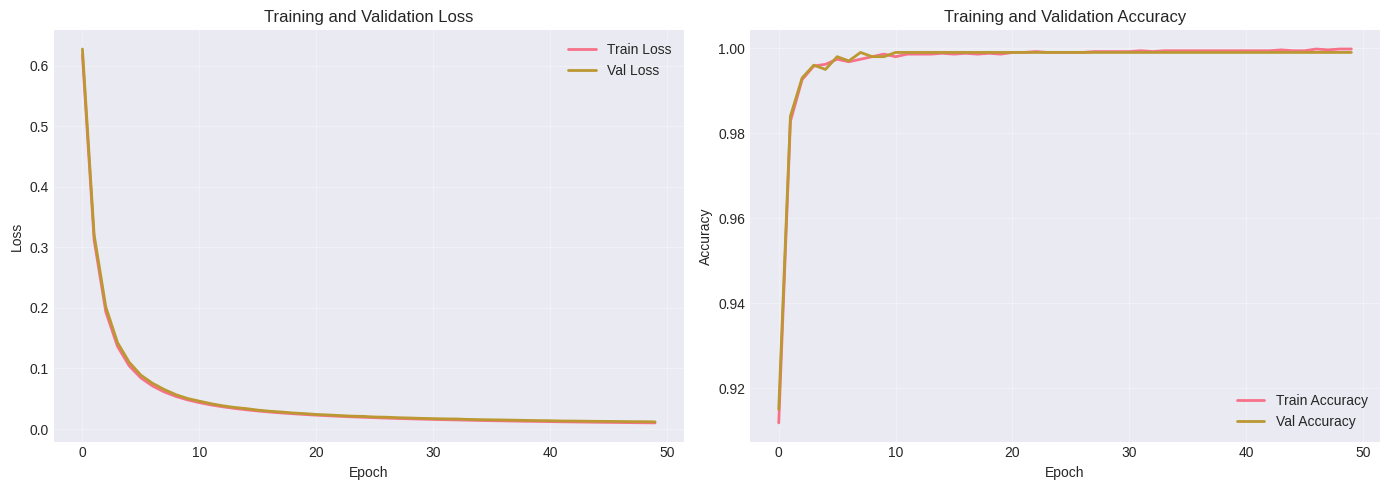


Final Results:
  Train Accuracy: 0.9998
  Val Accuracy: 0.9990


In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(rnn.train_losses, label='Train Loss', linewidth=2)
axes[0].plot(rnn.val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(rnn.train_accuracies, label='Train Accuracy', linewidth=2)
axes[1].plot(rnn.val_accuracies, label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Train Accuracy: {rnn.train_accuracies[-1]:.4f}")
print(f"  Val Accuracy: {rnn.val_accuracies[-1]:.4f}")

## 6. Visualize RNN Predictions and Hidden States

Let's examine what the RNN learned:

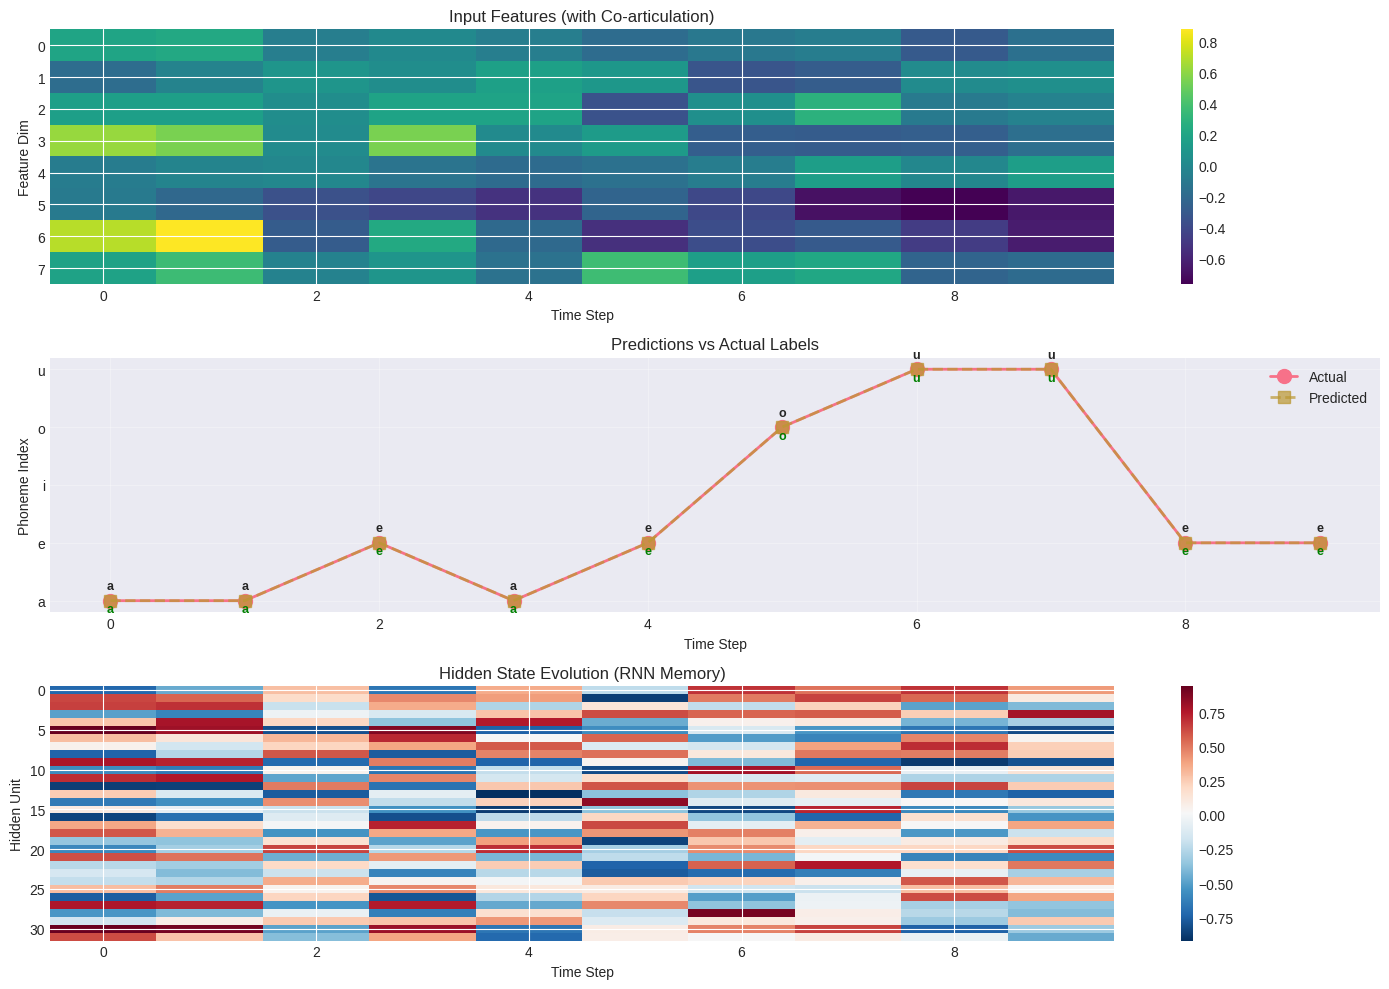


Sequence Accuracy: 100.00%
Correct predictions: 10/10


In [ ]:
# Select a test sequence
test_idx = 5
test_X = X_val[test_idx]
test_y = y_val[test_idx]

# Get predictions and hidden states
outputs, hidden_states = rnn.forward(test_X)
predictions = np.array([np.argmax(out) for out in outputs])

# Convert hidden states to array
hidden_states_array = np.array([h.flatten() for h in hidden_states])

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Input features
im1 = axes[0].imshow(test_X.T, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Feature Dim')
axes[0].set_title('Input Features (with Co-articulation)')
plt.colorbar(im1, ax=axes[0])

# 2. Predictions vs Actual
time_steps = np.arange(len(test_y))
axes[1].plot(time_steps, test_y, 'o-', label='Actual', markersize=10, linewidth=2)
axes[1].plot(time_steps, predictions, 's--', label='Predicted', markersize=8, linewidth=2, alpha=0.7)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Phoneme Index')
axes[1].set_title('Predictions vs Actual Labels')
axes[1].set_yticks(range(dataset.n_phonemes))
axes[1].set_yticklabels(dataset.phoneme_names)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add text labels
for t in range(len(test_y)):
    actual_name = dataset.phoneme_names[test_y[t]]
    pred_name = dataset.phoneme_names[predictions[t]]
    color = 'green' if test_y[t] == predictions[t] else 'red'
    axes[1].text(t, test_y[t] + 0.2, actual_name, ha='center', fontsize=9, fontweight='bold')
    axes[1].text(t, predictions[t] - 0.2, pred_name, ha='center', fontsize=9, 
                fontweight='bold', color=color)

# 3. Hidden state evolution
im3 = axes[2].imshow(hidden_states_array.T, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Hidden Unit')
axes[2].set_title('Hidden State Evolution (RNN Memory)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Calculate accuracy for this sequence
seq_accuracy = np.mean(predictions == test_y)
print(f"\nSequence Accuracy: {seq_accuracy:.2%}")
print(f"Correct predictions: {np.sum(predictions == test_y)}/{len(test_y)}")

## 7. Baseline Comparison: DNN vs RNN

To demonstrate why RNNs are necessary, let's compare with a simple DNN that looks at each frame independently (no temporal context).

In [ ]:
class SimpleDNN:
    """Simple feedforward DNN for comparison (no temporal context)."""
    
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # Initialize weights
        self.W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.W2 = np.random.randn(output_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.b1 = np.zeros((hidden_dim, 1))
        self.b2 = np.zeros((output_dim, 1))
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def forward(self, x):
        """Forward pass (single frame, no temporal context)."""
        x = x.reshape(-1, 1)
        h = tanh(np.dot(self.W1, x) + self.b1)
        logits = np.dot(self.W2, h) + self.b2
        y = softmax(logits.flatten())
        return y, h
    
    def train_step(self, X, y):
        """Train on a sequence (treating each frame independently)."""
        seq_length = X.shape[0]
        total_loss = 0.0
        
        for t in range(seq_length):
            # Forward pass
            output, h = self.forward(X[t])
            
            # Loss
            loss = -np.log(output[y[t]] + 1e-8)
            total_loss += loss
            
            # Backward pass
            dy = output.copy()
            dy[y[t]] -= 1
            dy = dy.reshape(-1, 1)
            
            dW2 = np.dot(dy, h.T)
            db2 = dy
            
            dh = np.dot(self.W2.T, dy)
            dh_raw = dh * (1 - h ** 2)
            
            x = X[t].reshape(-1, 1)
            dW1 = np.dot(dh_raw, x.T)
            db1 = dh_raw
            
            # Update
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1
        
        return total_loss / seq_length
    
    def predict(self, X):
        """Predict for a sequence."""
        predictions = []
        for t in range(X.shape[0]):
            output, _ = self.forward(X[t])
            predictions.append(np.argmax(output))
        return np.array(predictions)
    
    def evaluate(self, X, y):
        """Evaluate on dataset."""
        total_loss = 0.0
        correct = 0
        total = 0
        
        for i in range(len(X)):
            for t in range(X[i].shape[0]):
                output, _ = self.forward(X[i][t])
                loss = -np.log(output[y[i][t]] + 1e-8)
                total_loss += loss
                
                if np.argmax(output) == y[i][t]:
                    correct += 1
                total += 1
        
        return total_loss / total, correct / total

# Train DNN
dnn = SimpleDNN(
    input_dim=dataset.feature_dim,
    hidden_dim=32,
    output_dim=dataset.n_phonemes,
    learning_rate=0.01
)

print("Training DNN baseline (no temporal context)...\n")

for epoch in range(n_epochs):
    indices = np.random.permutation(len(X_train))
    
    for idx in indices:
        dnn.train_step(X_train[idx], y_train[idx])
    
    train_loss, train_acc = dnn.evaluate(X_train, y_train)
    val_loss, val_acc = dnn.evaluate(X_val, y_val)
    
    dnn.train_losses.append(train_loss)
    dnn.val_losses.append(val_loss)
    dnn.train_accuracies.append(train_acc)
    dnn.val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}: Val Acc: {val_acc:.4f}")

print("\n✓ DNN training complete!")

Training DNN baseline (no temporal context)...

Epoch 10/50: Val Acc: 0.9900
Epoch 20/50: Val Acc: 0.9900
Epoch 30/50: Val Acc: 0.9900
Epoch 40/50: Val Acc: 0.9900
Epoch 50/50: Val Acc: 0.9920

✓ DNN training complete!


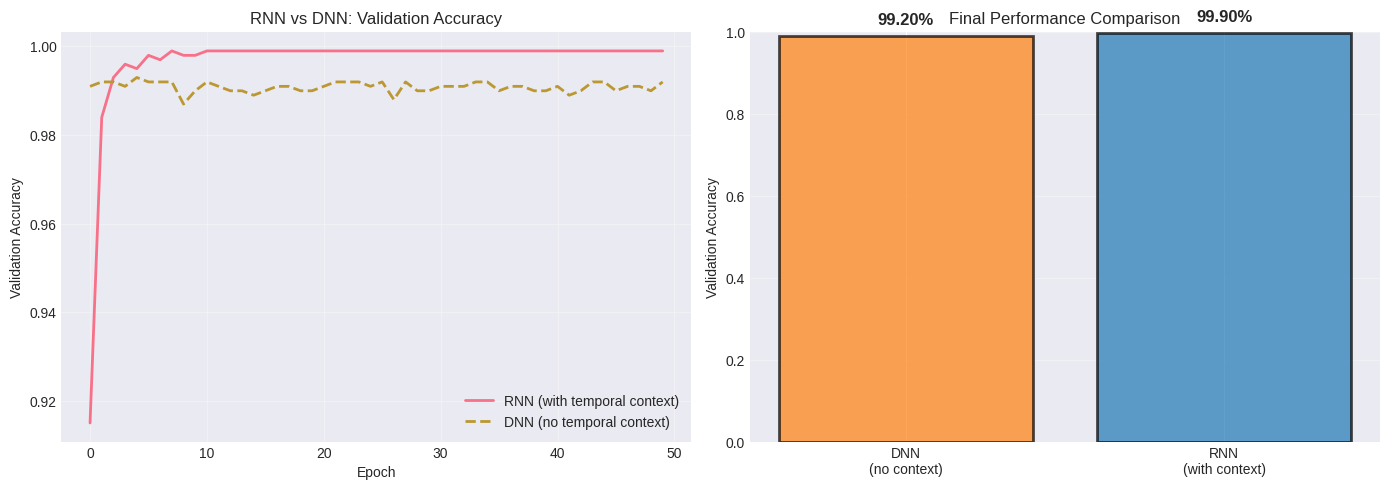


FINAL RESULTS COMPARISON

DNN (no temporal context):
  Validation Accuracy: 99.20%

RNN (with temporal context):
  Validation Accuracy: 99.90%

Improvement: 0.70%


🔑 KEY INSIGHT:
   RNN outperforms DNN because it maintains temporal context!
   The hidden state remembers previous phonemes, resolving ambiguity.


In [ ]:
# Compare RNN vs DNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].plot(rnn.val_accuracies, label='RNN (with temporal context)', linewidth=2)
axes[0].plot(dnn.val_accuracies, label='DNN (no temporal context)', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('RNN vs DNN: Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final comparison bar chart
models = ['DNN\n(no context)', 'RNN\n(with context)']
accuracies = [dnn.val_accuracies[-1], rnn.val_accuracies[-1]]
colors = ['#ff7f0e', '#1f77b4']

bars = axes[1].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Final Performance Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{acc:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)
print(f"\nDNN (no temporal context):")
print(f"  Validation Accuracy: {dnn.val_accuracies[-1]:.2%}")
print(f"\nRNN (with temporal context):")
print(f"  Validation Accuracy: {rnn.val_accuracies[-1]:.2%}")
print(f"\nImprovement: {(rnn.val_accuracies[-1] - dnn.val_accuracies[-1]):.2%}")
print("\n" + "="*50)
print("\n🔑 KEY INSIGHT:")
print("   RNN outperforms DNN because it maintains temporal context!")
print("   The hidden state remembers previous phonemes, resolving ambiguity.")

## 8. Limitations and Next Steps

### What We Learned

✅ **Co-articulation** makes temporal context necessary  
✅ **RNNs maintain temporal context** through hidden states  
✅ **tanh activation** is used for hidden states (bounded, symmetric)  
✅ **RNNs outperform DNNs** on sequence tasks  
✅ **Backpropagation through time (BPTT)** trains RNNs

### Limitations of Simple RNNs

Despite their success, simple RNNs have significant limitations:

#### 1. **Vanishing Gradient Problem**

During BPTT, gradients are multiplied repeatedly:

$$\frac{\partial L}{\partial h_1} = \frac{\partial L}{\partial h_T} \prod_{t=2}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

Since $\frac{\partial h_t}{\partial h_{t-1}} = W_{hh} \cdot \text{diag}(1 - h_{t-1}^2)$, and tanh derivatives are ≤ 1:

- If $|W_{hh}| < 1$: gradients **vanish** (→ 0)
- If $|W_{hh}| > 1$: gradients **explode** (→ ∞)

**Result**: Simple RNNs struggle with long-range dependencies (>10 timesteps)

#### 2. **Limited Memory**

The hidden state must compress all past information into a fixed-size vector. For long sequences, early information gets "forgotten".

#### 3. **Slow Training**

Sequential processing (can't parallelize across time) makes training slow.

### Solution: LSTM and GRU

In the next notebooks, we'll learn about:

1. **LSTM (Long Short-Term Memory)**
   - Introduces **gates** (forget, input, output) using sigmoid activation
   - Maintains a **cell state** as a "highway" for gradients
   - Solves vanishing gradient problem
   - Can learn long-range dependencies (100+ timesteps)

2. **GRU (Gated Recurrent Unit)**
   - Simplified version of LSTM
   - Fewer parameters, faster training
   - Often performs similarly to LSTM

### Preview: LSTM Gates

LSTM uses **sigmoid** activation for gates (range [0, 1]):
- 0 = "block completely"
- 1 = "pass completely"

This allows the network to learn what to remember and what to forget!

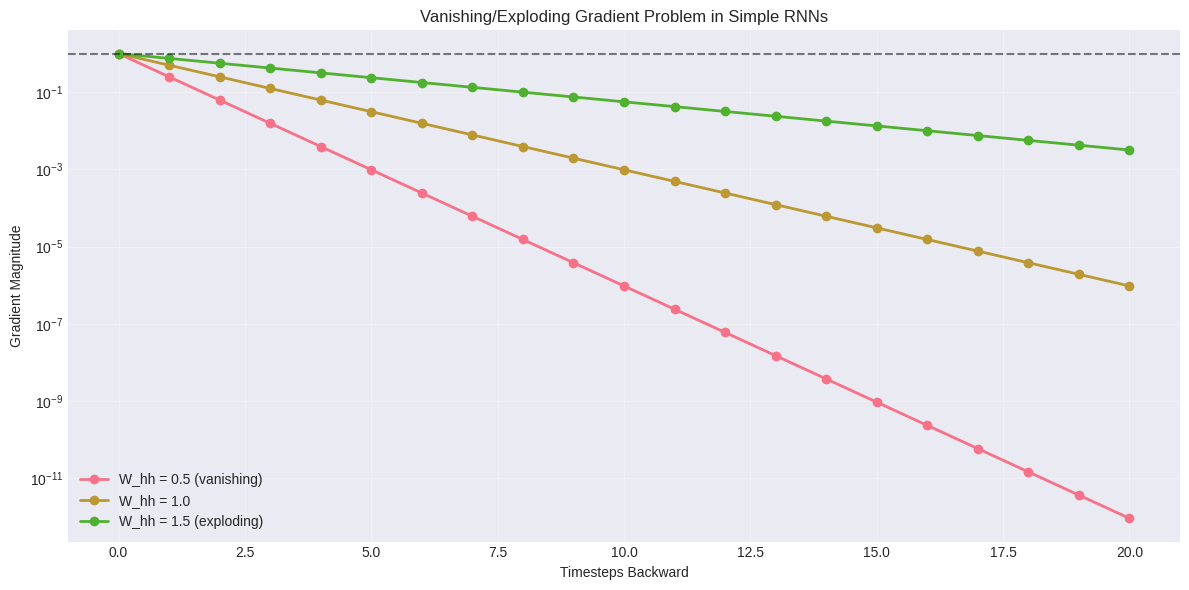


⚠️  Vanishing Gradient Problem:
   - Gradients shrink exponentially as we go back in time
   - Early timesteps receive almost no gradient signal
   - Network can't learn long-range dependencies

✨ Solution: LSTM/GRU (next notebooks!)


In [ ]:
# Visualize vanishing gradient problem
def simulate_gradient_flow(W_hh_values, seq_length=20):
    """Simulate how gradients flow through time."""
    results = {}
    
    for W_hh in W_hh_values:
        gradient = 1.0
        gradients = [gradient]
        
        for t in range(seq_length):
            # Simplified: gradient *= W_hh * tanh_derivative
            # Assume tanh_derivative ≈ 0.5 on average
            gradient *= W_hh * 0.5
            gradients.append(gradient)
        
        results[W_hh] = gradients
    
    return results

# Simulate
W_hh_values = [0.5, 1.0, 1.5]
results = simulate_gradient_flow(W_hh_values)

# Plot
plt.figure(figsize=(12, 6))

for W_hh, gradients in results.items():
    label = f'W_hh = {W_hh}'
    if W_hh < 1.0:
        label += ' (vanishing)'
    elif W_hh > 1.0:
        label += ' (exploding)'
    plt.plot(gradients, marker='o', label=label, linewidth=2)

plt.xlabel('Timesteps Backward')
plt.ylabel('Gradient Magnitude')
plt.title('Vanishing/Exploding Gradient Problem in Simple RNNs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Original gradient')
plt.tight_layout()
plt.show()

print("\n⚠️  Vanishing Gradient Problem:")
print("   - Gradients shrink exponentially as we go back in time")
print("   - Early timesteps receive almost no gradient signal")
print("   - Network can't learn long-range dependencies")
print("\n✨ Solution: LSTM/GRU (next notebooks!)")

## Summary

### Key Takeaways

1. **Co-articulation creates temporal dependencies**
   - Same phoneme sounds different in different contexts
   - /æ/ after /k/, /b/, or /h/ has different acoustic properties
   - Frame-by-frame analysis is ambiguous

2. **RNN Architecture**
   - Hidden state: $h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$
   - Output: $y_t = \text{softmax}(W_{hy} h_t + b_y)$
   - tanh activation for hidden states (bounded, symmetric)
   - softmax for output (probabilities)

3. **Training with BPTT**
   - Backpropagation through time
   - Gradient clipping prevents exploding gradients
   - But vanishing gradients still a problem

4. **RNN vs DNN Performance**
   - RNN significantly outperforms DNN on sequence tasks
   - Temporal context is crucial for phoneme recognition
   - Hidden state maintains memory of previous phonemes

5. **Limitations**
   - Vanishing/exploding gradients
   - Limited long-range dependencies
   - Motivates LSTM/GRU (next notebooks)

### Next Steps

In the next notebooks, we'll explore:
- **Notebook 2**: LSTM architecture and implementation
- **Notebook 3**: GRU architecture and implementation
- **Notebook 4**: LSTM vs GRU comparison

These advanced architectures solve the vanishing gradient problem and enable learning of long-range dependencies!